# Data Loading and Transformation from Matrices to Link Counts


make sure to upload data (ie "od-demand-202010-150.npy", od_stop, od_time,etc) from local machine to google colab notebook instance by clicking on "upload files", on the left. They must be re-uploaded every time the notebook instance is closed and re-opened. However, it doesn't take a long time to transform all the data.   

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle




def load_data(fp = '', pickle = False):
    data = np.load(fp, allow_pickle = pickle )
    return data

# def load_stop_data(fp=''):
#     data = pickle.load(fp)
#     return data

def transform_matrix(matrix):
    """
    Assuming matrix is 10x10
    """
    link_counts = []
    for i in range(len(matrix)-1):
        sum = np.sum(matrix[0:i+1, i+1:])
        link_counts.append(sum)

    return link_counts

def transform_all(matrices):
    all_counts = []
    for i in range(len(matrices)):
        count = transform_matrix(matrices[i])
        all_counts.append(count)
    return all_counts
    


demand_matrices = load_data('od-demand-202010-150.npy')

stop_names = load_data('od_stop-202010-150.npy', pickle = True)
print("bus stops: ", stop_names[0:10])

dates = load_data('od_time-202010-150.npy')
dates.shape = [np.shape(dates)[0], 1]
print("dimensions of date data: ", np.shape(dates))

# Finally we transform the data from matrices to link counts
route_counts = transform_all(demand_matrices)
print("dimension of transformed matrices: ", np.shape(route_counts))












bus stops:  ['KDST' 'EGEV' 'HHLS' 'HHM' 'GLHO' 'NÆST' 'KLBV' 'RYST' 'HKP' 'NPST1']
dimensions of date data:  (5786, 1)
dimension of transformed matrices:  (5786, 9)


#Basic Plotting and Data Visualization




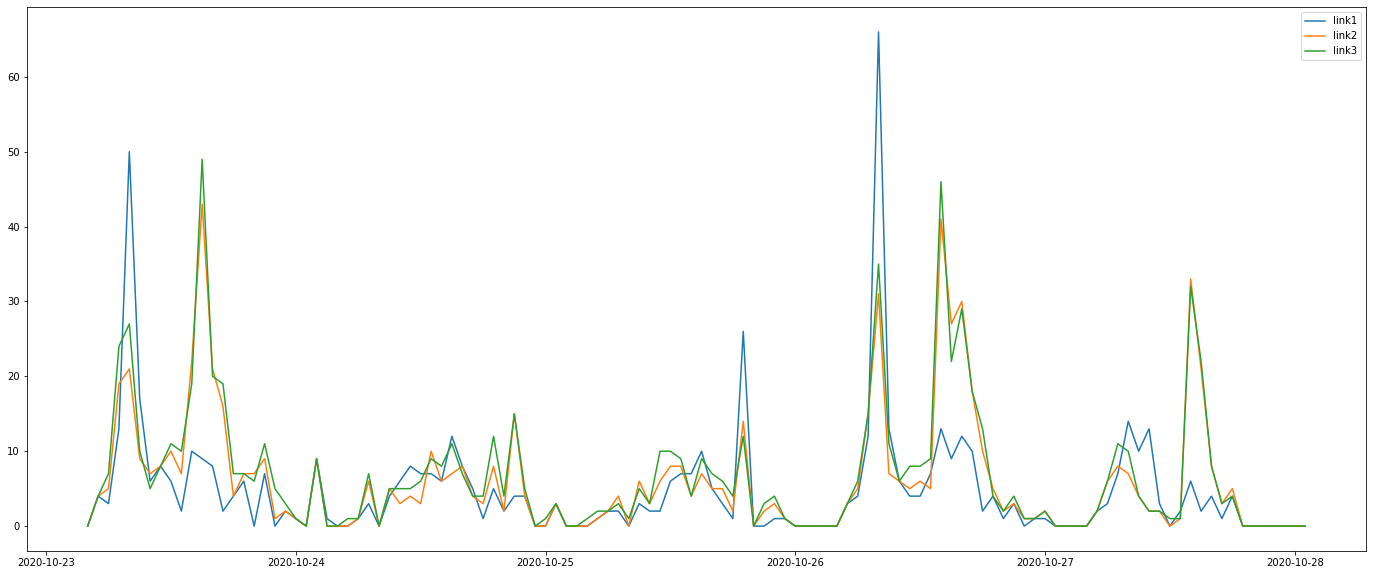

[0, 1, 2]


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def date_to_string(dates):
    date = ""
    new_dates = []
    for d in dates:
        date = str(d)[2:15]
        new_dates.append(date)
    return new_dates


def transform_to_plot_data(route_counts, start, stop):
    """ Transforms the route counts to a format that can be easily 
        plotted and visualized.
        We create a time series of data (in 1 hour intervals) for each link.
    """
    if not stop <= np.shape(route_counts)[0]:
        print("Error- interval end longer than route count matrix")
        return -1

    link_dict = {}
    for i in range(np.shape(route_counts)[1]):
        links = []
        link_num = i+1

        for j in range(start, stop):
            links.append(route_counts[j][i])

        link_dict[link_num] = links

    return link_dict


def plot_route_counts(route_counts, start, stop, links = range(len(route_counts[1])), plot_type = 'line'):
    """
    Plot the counts at each link over a given time interval.
    When entering in the links you wish to plot, subtract 1. 
    i.e. links = [0,1,2] if you wish to plot links 1, 2, 3.
    It's just an indexing thing. 
    """


    link_dict = transform_to_plot_data(route_counts, start, stop)
    fig = plt.figure(figsize=(24,10))
    
    if plot_type == 'line':
        for i in links:
            plt.plot(dates[start:stop], link_dict[i+1], label='link'+str(i+1))
    elif plot_type == 'bar':

        for i in links:
            plt.bar(list(np.arange(start, stop)), list(link_dict[i+1]))
            plt.xticks(np.arange(start, stop), date_to_string(dates[start:stop]), rotation = 90)

    plt.legend()
    plt.show()
    


links = [0,1,2]
plot_route_counts(route_counts, 5668, 5786, links)
print(links)



#Data Handling

In [3]:
from sklearn import preprocessing

def shuffle_in_unison(X, Y):
    n_elem = X.shape[0]
    indeces = np.random.permutation(n_elem)
    return X[indeces], Y[indeces]

X = np.array(route_counts) 
# normalized_X = preprocessing.normalize(X)
# Y = np.delete(normalized_X,0,0) # output is shifted by one row by deleting the first row
# X = np.delete(normalized_X,normalized_X.shape[0]-1, 0) # delete the last input because it has no output
# X_new = X
# Y = np.delete(X_new,0,0) # output is shifted by one row by deleting the first row
# X = np.delete(X_new,X_new.shape[0]-1, 0) # delete the last input because it has no output

look_back = 20
len_sequence = look_back
batch_size = 100
len_data = X.shape[0]
data = []
# create all possible sequences of length seq_len
for index in range(len_data - look_back): 
    data.append(X[index: index + look_back])
data = np.array(data)
X = data[:len_data,:-1,:]
Y = data[:len_data,-1,:]


num_features = X.shape[2]

# X, Y = shuffle_in_unison(X, Y)




In [4]:
class Dataset():
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(X, Y, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len_data*p_train)
    num_val = int(len_data*p_val)
    num_test = int(len_data*p_test)

    # Get inputs and targets for each partition
    inputs_train, targets_train = X[:num_train], Y[:num_train]  
    inputs_val, targets_val = X[num_train:num_train+num_val], Y[num_train:num_train+num_val]
    inputs_test, targets_test = X[-num_test:], Y[-num_test:]

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set


training_set, validation_set, test_set = create_datasets(X, Y, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 4628 samples in the training set.
We have 578 samples in the validation set.
We have 578 samples in the test set.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
def load_dataset():

    trainloader = torch.utils.data.DataLoader(
      dataset = training_set,
      batch_size= batch_size,
      num_workers = 0,
      shuffle= True
    )

    validationloader = torch.utils.data.DataLoader(
      dataset = validation_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= True
    )

    testloader = torch.utils.data.DataLoader(
      dataset = test_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= False
    )

    return trainloader, validationloader, testloader

trainloader, validationloader, testloader = load_dataset()

#Network Description

In [6]:


class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        # YOUR CODE HERE!
        self.lstm = nn.LSTM(input_size=num_features,
                         hidden_size=2*num_features,
                         num_layers=2,
                         bidirectional=False,
                         batch_first = True,
                         dropout = 0.6)
 
        
        # Output layer
        self.l_out = nn.Linear(in_features=2*num_features,
                            out_features=num_features,
                            bias=False)
        
        # self.dropout = nn.Dropout(p=0.6)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        # print(len(x.size()))
        # if len(x.size()) == 2:
        #   batch_size = 1
        # else:
        batch_size = x.shape[0]

        # x = x.view(batch_size , -1, 1)
        # x = x.permute(1, 0, 2)
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.contiguous().view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        # x = self.dropout(x)
        # x = nn.ReLU(x)
        
        x = torch.Tensor.reshape(x, (batch_size, len_sequence - 1, num_features))
        x = x[:, -1, :]
        return x

net = MyRecurrentNet()
net = net.float()
print(net)

MyRecurrentNet(
  (lstm): LSTM(9, 18, num_layers=2, batch_first=True, dropout=0.6)
  (l_out): Linear(in_features=18, out_features=9, bias=False)
)


Epoch 0, training loss: 1017.7227700117238, validation loss: 1588.652727278871
Epoch 10, training loss: 505.1103892544785, validation loss: 790.5401079118458
Epoch 20, training loss: 320.1710095615766, validation loss: 476.7571293919969
Epoch 30, training loss: 233.4947165882371, validation loss: 324.38259518105264
Epoch 40, training loss: 187.51735571858794, validation loss: 240.45136274185973
Epoch 50, training loss: 161.98299895264304, validation loss: 201.99408244096696
Epoch 60, training loss: 144.27397775279104, validation loss: 171.97684090690217
Epoch 70, training loss: 129.54215678987362, validation loss: 141.37232976471265
Epoch 80, training loss: 119.0992574139515, validation loss: 124.72301765626689
Epoch 90, training loss: 110.81318756538728, validation loss: 116.57924873853638
Epoch 100, training loss: 104.83341213743957, validation loss: 107.39437734214492
Epoch 110, training loss: 98.57701422741626, validation loss: 105.60573583160718
Epoch 120, training loss: 93.998808

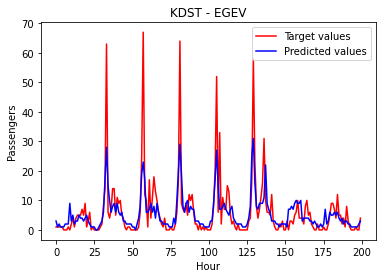

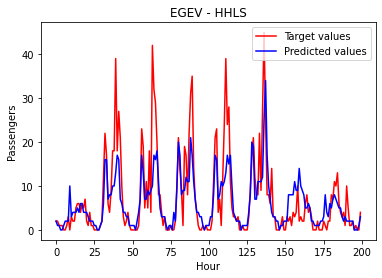

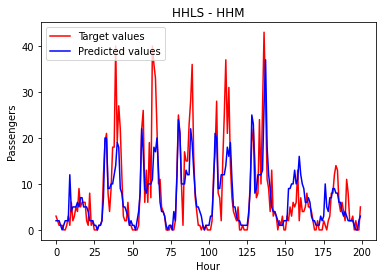

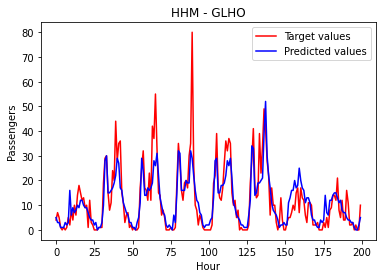

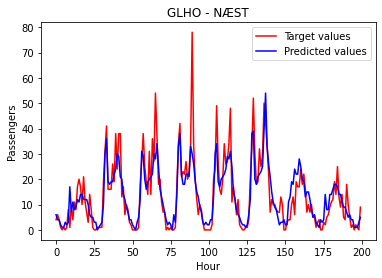

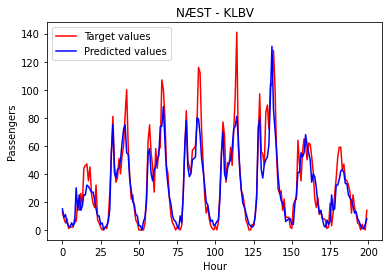

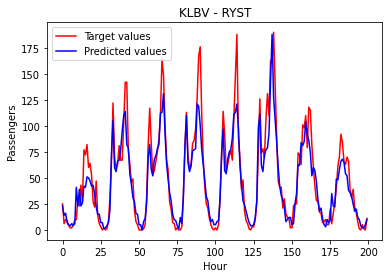

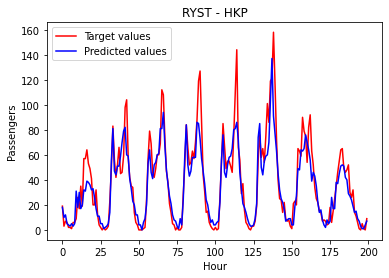

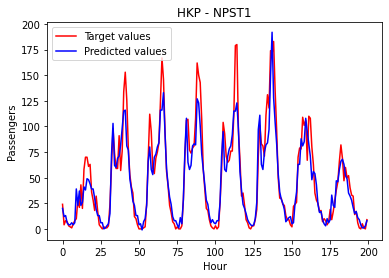

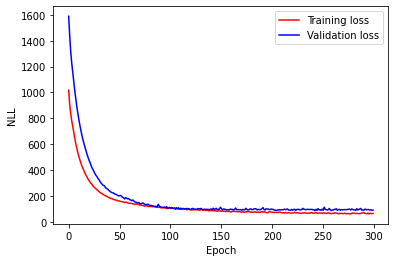

In [7]:
# Hyper-parameters
num_epochs = 300

# Initialize a new network
net = MyRecurrentNet()

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr=0.003)

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for _,(inputs, targets) in enumerate(validationloader):
        batch = inputs.shape[0]

        inputs= inputs.float()
        targets = targets.float()
        # Forward pass
        outputs = net(inputs)
        # Compute loss
        loss = criterion(outputs, targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy() * batch
    
    net.train()
    
    # For each sentence in training set
    for _,(inputs, targets) in enumerate(trainloader):
        batch = inputs.shape[0]

        inputs = inputs.float()
        targets = targets.float()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        # YOUR CODE HERE!
        loss = criterion(outputs, targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy() * batch
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

targets_test = []
outputs_test = []
# Get first sentence in test set
for _,(inputs, targets) in enumerate(testloader):
  inputs = inputs.float()
  targets = targets.float()
  targets_test = targets_test + targets.tolist()
  # Forward pass
  output = np.round(net.forward(inputs).data.numpy())
  outputs_test = outputs_test + output.tolist()

# Reduce the size to show better in plot
MAX_HOURS = 200
targets_test = targets_test[:MAX_HOURS]
outputs_test = outputs_test[:MAX_HOURS]

for i in range(0,num_features):
  hour = np.arange(len(targets_test))
  title = stop_names[i] + " - " +stop_names[i+1]
  plt.figure()
  plt.plot(hour, [link[i] for link in targets_test], 'r', label='Target values',)
  plt.plot(hour, [link[i] for link in outputs_test], 'b', label='Predicted values')
  plt.legend()
  plt.xlabel('Hour'), plt.ylabel('Passengers')
  plt.title(title)
  plt.show()

# Plot training and validation loss
epoch = np.arange(len(training_loss))

plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()